In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime
import itertools

%matplotlib inline
from finrl import config
from finrl import config_tickers
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

/home/henry/miniconda3/envs/finrl/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [2]:
from data_processor.indicator import add_all_indicators


In [3]:
import data_processor.config

In [4]:
price_df = pd.read_parquet("./data/sz50_price.parquet")
fund_df = pd.read_parquet("./data/sz50_fundament.parquet")


In [5]:
df = add_all_indicators(price_df, fund_df)


In [6]:
tmp_list = []
for tic in data_processor.config.trainable_sz50_2009:
    tmp_df = df[df['tic'] == tic]
    tmp_list.append(tmp_df)
    
df = pd.concat(tmp_list, ignore_index=True)
    

In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111716 entries, 0 to 111715
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            111716 non-null  datetime64[ns]
 1   tic             111716 non-null  object        
 2   open            111716 non-null  float64       
 3   high            111716 non-null  float64       
 4   low             111716 non-null  float64       
 5   close           111716 non-null  float64       
 6   volume          111716 non-null  object        
 7   amount          111716 non-null  float64       
 8   peTTM           111716 non-null  object        
 9   pbMRQ           111716 non-null  object        
 10  psTTM           111716 non-null  object        
 11  pcfNcfTTM       111716 non-null  object        
 12  SMA_20          111716 non-null  float64       
 13  SMA_60          111716 non-null  float64       
 14  SMA_120         111716 non-null  flo

In [8]:
train = data_split(df, "2009-01-01", "2020-01-01")
trade = data_split(df, "2020-01-01", "2022-01-01")


In [9]:
train.head()

,date,tic,open,high,low,close,volume,amount,peTTM,pbMRQ,...,macdhist,CCI,RSI,NATR,ADOSC,ROE,AssetStoEquity,Pnitoni,Nitogr,TaxBurden
0,2009-01-05,sh.600000,13.51,13.77,13.35,13.72,50314256,6.814876e+08,6.801765,2.038830,...,-0.086527,-34.837658,49.950845,5.038800,-1.004979e+07,0.296527,30.581132,1.000000,0.382923,0.760415
0,2009-01-05,sh.600028,7.10,7.21,7.06,7.19,36108566,2.583140e+08,26.040793,2.005619,...,-0.070653,-57.366548,38.495446,4.592384,-1.689824e+07,0.057675,2.504743,1.098779,0.013993,0.857051
0,2009-01-05,sh.600030,18.30,18.90,18.10,18.86,81897841,1.520775e+09,12.601752,2.371588,...,-0.337143,-66.768487,43.261199,5.195249,-7.418656e+07,0.113061,3.255677,0.917892,0.462209,0.790711
0,2009-01-05,sh.600031,14.29,15.05,14.27,15.00,16318953,2.409264e+08,15.758262,3.925210,...,-0.268367,-46.057530,45.121786,5.852320,-5.312837e+06,0.207962,2.461995,0.845326,0.117900,0.931708
0,2009-01-05,sh.600036,12.42,12.62,12.24,12.59,62110710,7.701047e+08,7.628686,2.215404,...,-0.078920,-52.975496,46.490823,5.131335,-1.570076e+07,0.250706,18.855408,1.000000,0.446783,0.770469


In [10]:
indicators = [
    "peTTM",
    "pbMRQ",
    "psTTM",
    "pcfNcfTTM",
    "SMA_20",
    "SMA_60",
    "SMA_120",
    "macdhist",
    "CCI",
    "RSI",
    "NATR",
    "ADOSC",
    "ROE",
    "AssetStoEquity",
    "Pnitoni",
    "Nitogr",
    "TaxBurden",
]


In [11]:
n_indicators = len(indicators)
n_indicators


17

In [12]:
stock_dimension = len(df.tic.unique())
stock_dimension


34

In [13]:
state_space = 1 + (2 + n_indicators) * stock_dimension
state_space


647

In [14]:
env_kwargs = {
    "hmax": 100,
    # initial_amount = 1000000, and hold no shares at beginning.
    "initial_list": [10000000] + [0 for i in range(stock_dimension)],
    # buy and sell cost for each stock
    "buy_cost_pct": [0.001] * stock_dimension,
    "sell_cost_pct": [0.001] * stock_dimension,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": indicators,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
}

e_train_gym = StockTradingEnv(df=train, **env_kwargs)

In [15]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [16]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [17]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=10000)

In [18]:
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

In [19]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym)

hit end!


In [23]:
df_account_value.tail()

,date,account_value
481,2021-12-27,1.685002e+07
482,2021-12-28,1.691196e+07
483,2021-12-29,1.599967e+07
484,2021-12-30,1.595730e+07
485,2021-12-31,1.620644e+07


In [34]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.284479
Cumulative returns     0.620644
Annual volatility      0.254414
Sharpe ratio           1.113907
Calmar ratio           1.146507
Stability              0.848626
Max drawdown          -0.248127
Omega ratio            1.217139
Sortino ratio          1.600609
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.092328
Daily value at risk   -0.030929
dtype: float64


In [42]:
from data_processor.ChinaStockDownloader import single_stock_query

baseline_df = single_stock_query("2020-01-01", "2022-01-01", "sh.000016")

login success!
logout success!


In [56]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = single_stock_query("2020-01-01", "2022-01-01", "sh.000016")
baseline_df = baseline_df.apply(pd.to_numeric, errors='ignore')
stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
login success!
logout success!
Annual return          0.030354
Cumulative returns     0.059365
Annual volatility      0.207159
Sharpe ratio           0.248251
Calmar ratio           0.127942
Stability              0.258280
Max drawdown          -0.237251
Omega ratio            1.043889
Sortino ratio          0.346802
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.977931
Daily value at risk   -0.025896
dtype: float64


In [108]:
test_ret = get_daily_return(df_account_value)
base_ret = get_daily_return(baseline_df, 'close')

In [99]:
print("==============Compare to SZ50===========")
%matplotlib inline

import pyfolio

==============Compare to SZ50===========


In [107]:
qs.utils.download_returns('FB').index

DatetimeIndex(['2012-05-18', '2012-05-21', '2012-05-22', '2012-05-23',
               '2012-05-24', '2012-05-25', '2012-05-29', '2012-05-30',
               '2012-05-31', '2012-06-01',
               ...
               '2022-03-21', '2022-03-22', '2022-03-23', '2022-03-24',
               '2022-03-25', '2022-03-28', '2022-03-29', '2022-03-30',
               '2022-03-31', '2022-04-01'],
              dtype='datetime64[ns]', name='Date', length=2485, freq=None)

In [113]:
test_ret.index = pd.DatetimeIndex(test_ret.index.date)
base_ret.index = pd.DatetimeIndex(base_ret.index.date)

In [116]:
import quantstats as qs

qs.reports.html(test_ret, base_ret)

Start date,2020-01-02
End date,2021-12-31
Total months,23
,Backtest
Annual return,28.448%
Cumulative returns,62.064%
Annual volatility,25.441%
Sharpe ratio,1.11
Calmar ratio,1.15
Stability,0.85
Max drawdown,-24.813%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.81,2021-02-10,2021-03-09,2021-06-10,87
1,21.14,2021-07-01,2021-09-16,NaT,NaN
2,9.26,2020-09-02,2020-09-09,2020-12-10,72
3,7.49,2021-01-13,2021-01-28,2021-02-08,19
4,7.34,2020-07-13,2020-07-16,2020-07-30,14


Stress Events,mean,min,max
New Normal,0.11%,-6.00%,5.00%


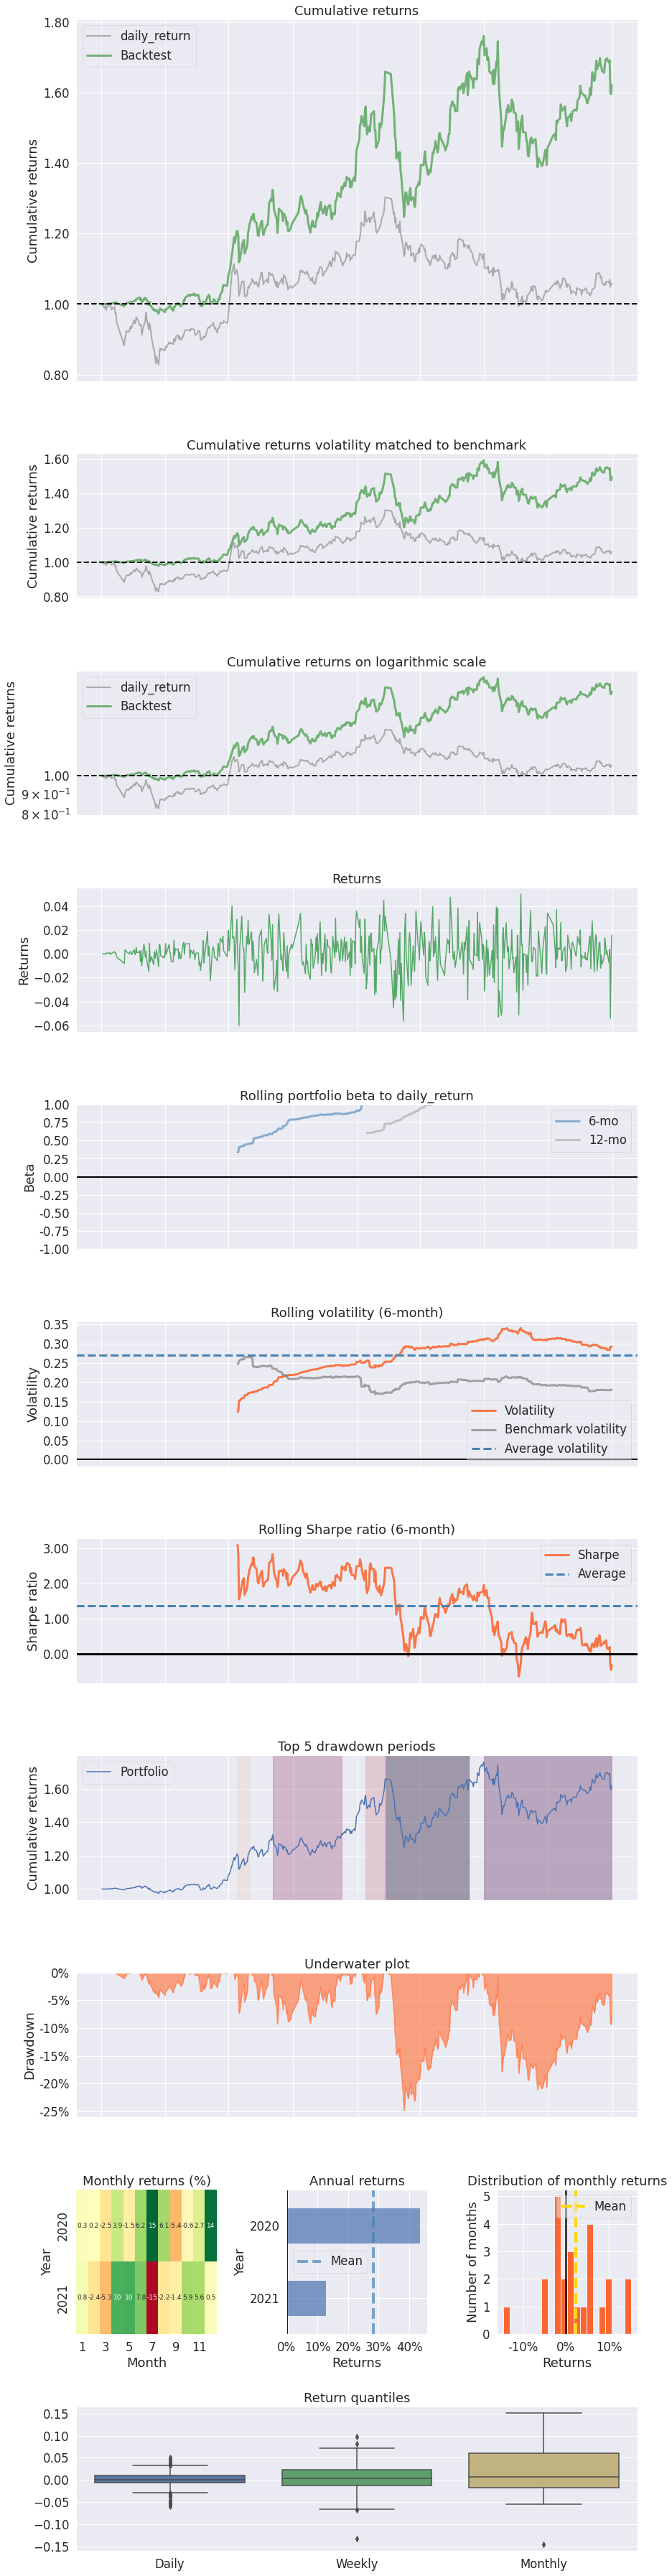

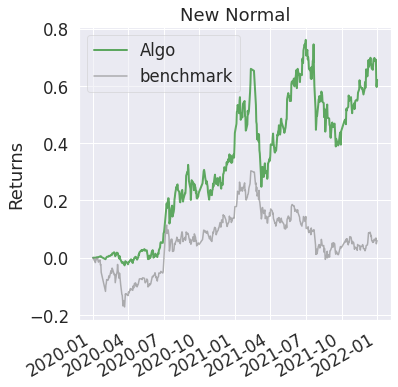

In [115]:
pyfolio.create_full_tear_sheet(returns=test_ret, benchmark_rets=base_ret)